# Problem Definition and Data Collection

## import libraries

In [1]:
pip install tqdm

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from ipywidgets import interact, Dropdown
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.linear_model import LinearRegression
import warnings
from tqdm import tqdm

## Data Import

In [3]:
pollutant_files = {
        'CO': 'https://huggingface.co/datasets/hsn79m/Tehran-Airnow/resolve/main/CO_Tehran.xlsx',
        'NO2': 'https://huggingface.co/datasets/hsn79m/Tehran-Airnow/resolve/main/NO2_Tehran.xlsx',
        'O3': 'https://huggingface.co/datasets/hsn79m/Tehran-Airnow/resolve/main/O3_Tehran.xlsx',
        'PM2.5': 'https://huggingface.co/datasets/hsn79m/Tehran-Airnow/resolve/main/PM2.5_Tehran.xlsx',
        'PM10': 'https://huggingface.co/datasets/hsn79m/Tehran-Airnow/resolve/main/PM10_Tehran.xlsx',
        'SO2': 'https://huggingface.co/datasets/hsn79m/Tehran-Airnow/resolve/main/SO2_Tehran.xlsx'
}

In [4]:
pollutant_df={}


for pollutant, filename in tqdm(pollutant_files.items()):
  pollutant_df[pollutant] = pd.read_excel(filename)

100%|██████████| 6/6 [04:59<00:00, 49.85s/it]


In [5]:
pollutant_df.keys()

dict_keys(['CO', 'NO2', 'O3', 'PM2.5', 'PM10', 'SO2'])

In [6]:
station_list = [
        'Aghdasieyeh',
        'Darus',
        'Zone 2',
        'Zone 4',
        'Zone 10',
        'Zone 11',
        'Zone 12',
        'Zone 16',
        'Zone 19',
        'Zone 21',
        'Zone 22',
        'Fath',
        'Golbarg',
        'Mahallati',
        'Maoudieyeh',
        'Park-e-Roz',
        'Piroozi',
        'Poonak',
        'Setad-e-Bohran',
        'Sadr',
        'Shad abad',
        'Shahr-e-Rey',
        'Sharif',
        'Tarbiat Modares',
        'Ati Saz',
        'Cheshmeh',
        'Geophysic',
        'Imam Khomeini',
        'Pardisan',
        'Park-e-Shokoofeh',
        'Shahid Beheshti University',
        'Sorkhe Hesar',
]

In [7]:
list_of_all_dfs = list(pollutant_df.values())
common_columns = set(list_of_all_dfs[0].columns)

for df in list_of_all_dfs[1:]:
  common_columns.intersection_update(df.columns)

common_station_cols = [station for station in station_list if station in common_columns]

In [8]:
all_processed_dfs = []

for pollutant_name, df in pollutant_df.items():
    temp_df = df.copy()
    temp_df['datetime'] = pd.to_datetime(temp_df[['Year', 'Month', 'Day', 'Hour']], errors='coerce')
    temp_df = temp_df.dropna(subset=['datetime']).set_index('datetime')
    temp_df = temp_df[common_station_cols]
    temp_df = temp_df.add_prefix(f"{pollutant_name}_")
    all_processed_dfs.append(temp_df)

combined_df = pd.concat(all_processed_dfs, axis=1).sort_index()

In [9]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96432 entries, 2011-03-21 00:00:00 to 2022-03-20 23:00:00
Columns: 114 entries, CO_Aghdasieyeh to SO2_Imam Khomeini
dtypes: float64(114)
memory usage: 84.6 MB


## Plotting

In [10]:
df_daily = combined_df.resample('D').mean()

In [11]:
pollutants_to_plot = list(pollutant_df.keys())

def plot_daily_station_lineplot(station):
    fig, axes = plt.subplots(nrows=len(pollutants_to_plot), ncols=1, figsize=(18, 3 * len(pollutants_to_plot)), sharex=True)
    fig.suptitle(f'Daily Average of Pollutants at "{station}" Station', fontsize=20, y=1.0)

    for i, pollutant in enumerate(pollutants_to_plot):
      col_to_plot = f'{pollutant}_{station}'

      sns.lineplot(ax=axes[i], data=df_daily, x=df_daily.index, y=col_to_plot, color=f'C{i}')
      axes[i].set_ylabel(f'Daily Avg {pollutant}')
      axes[i].grid(True, which='both', linestyle='--', linewidth=0.5)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

interact(plot_daily_station_lineplot, station=Dropdown(options=common_station_cols, description='Select Station:'));

interactive(children=(Dropdown(description='Select Station:', options=('Aghdasieyeh', 'Zone 2', 'Zone 4', 'Zon…

In [12]:
def plot_daily_station_boxplot(pollutant):

    station_data = []
    for station in common_station_cols:
      col_name = f"{pollutant}_{station}"
      temp_df = df_daily.copy()
      temp_df.rename(columns={col_name: 'concentration'}, inplace=True)
      temp_df['station'] = station
      station_data.append(temp_df)

    long_df = pd.concat(station_data)
    long_df.dropna(subset=['concentration'], inplace=True)

    plt.figure(figsize=(18, 10))
    order = long_df.groupby('station')['concentration'].median().sort_values(ascending=False).index
    sns.boxplot(data=long_df, x='station', y='concentration', order=order)
    plt.title(f'Daily Distribution of {pollutant} Across Stations', fontsize=16)
    plt.xlabel('Station', fontsize=12)
    plt.ylabel(f'Daily Avg {pollutant} Concentration', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

interact(plot_daily_station_boxplot, pollutant=Dropdown(options=pollutants_to_plot, description='Select Pollutant:'));

interactive(children=(Dropdown(description='Select Pollutant:', options=('CO', 'NO2', 'O3', 'PM2.5', 'PM10', '…

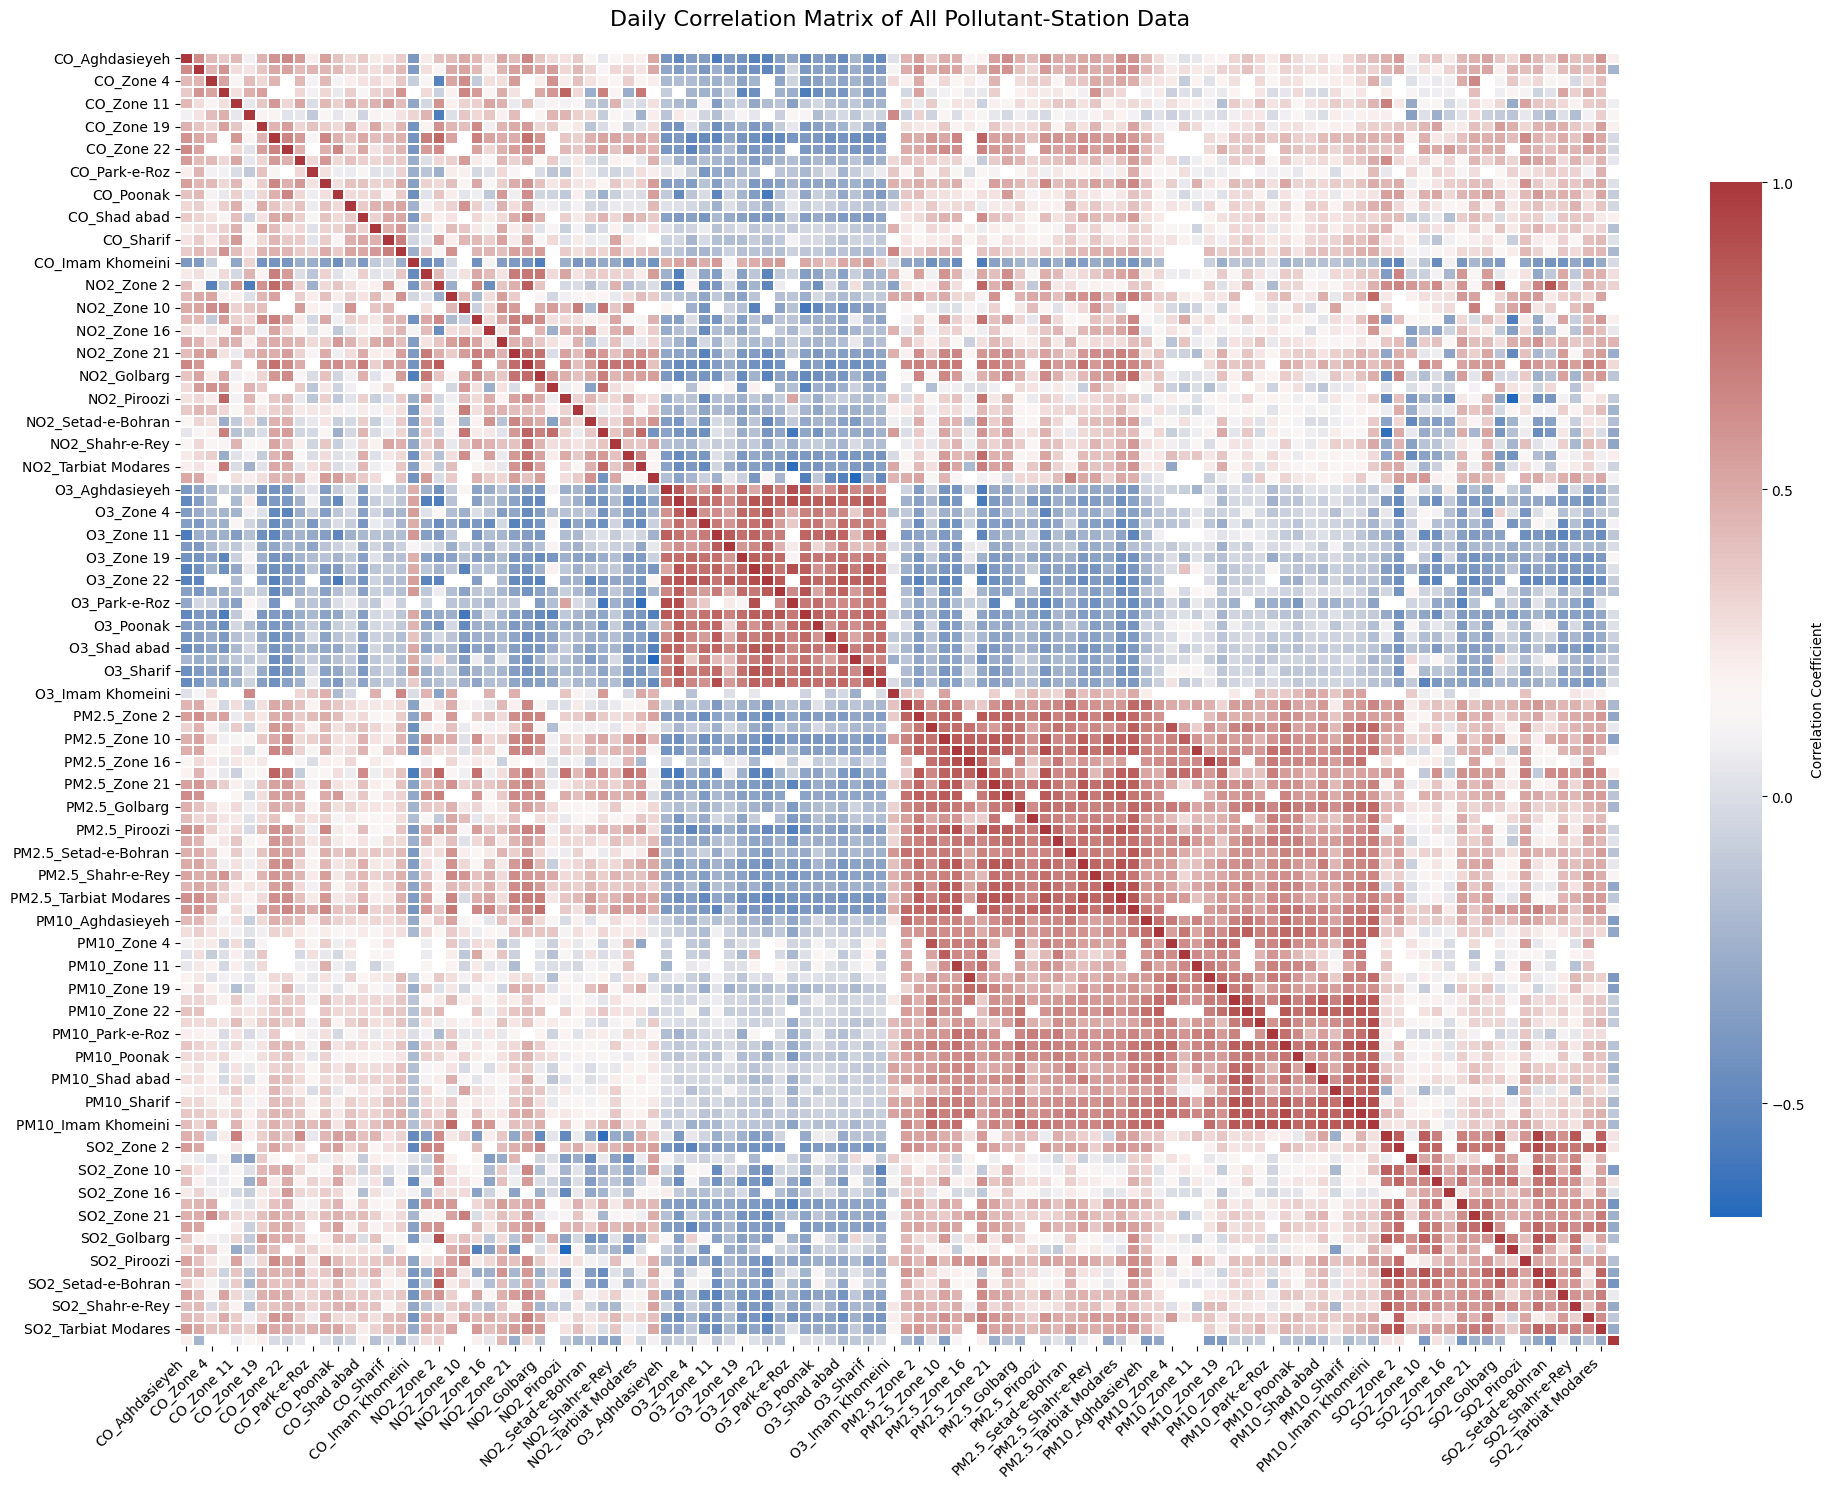

In [13]:
daily_correlation_matrix = df_daily.corr()

plt.figure(figsize=(20, 15))
sns.heatmap(
    daily_correlation_matrix,
    cmap="vlag",
    linewidths=0.1,
    cbar_kws={
        "shrink": 0.8,
        "label": "Correlation Coefficient",
        "ticks": [-1, -0.5, 0, 0.5, 1]
    }
)

plt.title(
    'Daily Correlation Matrix of All Pollutant-Station Data',
    fontsize=16,
    pad=20
)

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [14]:
df_daily_patterns = df_daily.copy()
df_daily_patterns['month'] = df_daily_patterns.index.month
df_daily_patterns['day_of_week'] = df_daily_patterns.index.day_name()

def plot_temporal_patterns(pollutant, station):
    col_name = f"{pollutant}_{station}"

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    fig.suptitle(f'Temporal Patterns for {pollutant} at {station} Station', fontsize=16)

    monthly_avg = df_daily_patterns.groupby('month')[col_name].mean()
    sns.lineplot(data=monthly_avg, marker='o', ax=ax1)
    ax1.set_title('Average by Month')
    ax1.set_xlabel('Month')
    ax1.set_ylabel(f'Daily Avg {pollutant}')
    ax1.grid(True)

    days_order = ['Saturday','Sunday','Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    weekly_avg = df_daily_patterns.groupby('day_of_week')[col_name].mean().reindex(days_order)
    sns.barplot(x=weekly_avg.index, y=weekly_avg.values, ax=ax2)
    ax2.set_title('Average by Day of Week')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel(f'Daily Avg {pollutant}')
    ax2.grid(True, axis='y')
    plt.xticks(rotation=45)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

interact(plot_temporal_patterns,
         pollutant=Dropdown(options=pollutants_to_plot, description='Select Pollutant:'),
         station=Dropdown(options=common_station_cols, description='Select Station:'));

interactive(children=(Dropdown(description='Select Pollutant:', options=('CO', 'NO2', 'O3', 'PM2.5', 'PM10', '…

In [15]:
def freq_hist_plot(pollutant,station):
  col_name = f"{pollutant}_{station}"
  plt.figure(figsize=(10, 6))
  sns.histplot(combined_df[col_name].dropna(), kde=True, bins=50)

  plt.title(f'Distribution of {pollutant} Levels at {station} Station')
  plt.xlabel(f'{pollutant} Concentration')
  plt.ylabel('Frequency')
  plt.show()


interact(freq_hist_plot,
         pollutant=Dropdown(options=pollutants_to_plot, description='Select Pollutant:'),
         station=Dropdown(options=common_station_cols, description='Select Station:'));

interactive(children=(Dropdown(description='Select Pollutant:', options=('CO', 'NO2', 'O3', 'PM2.5', 'PM10', '…

# Data Preprocessing

## AQI Calc

In [16]:
BREAKPOINTS = {
    'O3_8hr': [
        {'I_lo': 0, 'I_hi': 50, 'C_lo': 0.000, 'C_hi': 0.054},
        {'I_lo': 51, 'I_hi': 100, 'C_lo': 0.055, 'C_hi': 0.070},
        {'I_lo': 101, 'I_hi': 150, 'C_lo': 0.071, 'C_hi': 0.085},
        {'I_lo': 151, 'I_hi': 200, 'C_lo': 0.086, 'C_hi': 0.105},
        {'I_lo': 201, 'I_hi': 300, 'C_lo': 0.106, 'C_hi': 0.200},
    ],
    'O3_1hr': [
        {'I_lo': 101, 'I_hi': 150, 'C_lo': 0.125, 'C_hi': 0.164},
        {'I_lo': 151, 'I_hi': 200, 'C_lo': 0.165, 'C_hi': 0.204},
        {'I_lo': 201, 'I_hi': 300, 'C_lo': 0.205, 'C_hi': 0.404},
        {'I_lo': 301, 'I_hi': 400, 'C_lo': 0.405, 'C_hi': 0.504},
        {'I_lo': 401, 'I_hi': 500, 'C_lo': 0.505, 'C_hi': 0.604},
    ],
    'PM2.5_24hr': [
        {'I_lo': 0, 'I_hi': 50, 'C_lo': 0.0, 'C_hi': 12.0},
        {'I_lo': 51, 'I_hi': 100, 'C_lo': 12.1, 'C_hi': 35.4},
        {'I_lo': 101, 'I_hi': 150, 'C_lo': 35.5, 'C_hi': 55.4},
        {'I_lo': 151, 'I_hi': 200, 'C_lo': 55.5, 'C_hi': 150.4},
        {'I_lo': 201, 'I_hi': 300, 'C_lo': 150.5, 'C_hi': 250.4},
        {'I_lo': 301, 'I_hi': 400, 'C_lo': 250.5, 'C_hi': 350.4},
        {'I_lo': 401, 'I_hi': 500, 'C_lo': 350.5, 'C_hi': 500.4},
    ],
    'PM10_24hr': [
        {'I_lo': 0, 'I_hi': 50, 'C_lo': 0, 'C_hi': 54},
        {'I_lo': 51, 'I_hi': 100, 'C_lo': 55, 'C_hi': 154},
        {'I_lo': 101, 'I_hi': 150, 'C_lo': 155, 'C_hi': 254},
        {'I_lo': 151, 'I_hi': 200, 'C_lo': 255, 'C_hi': 354},
        {'I_lo': 201, 'I_hi': 300, 'C_lo': 355, 'C_hi': 424},
        {'I_lo': 301, 'I_hi': 400, 'C_lo': 425, 'C_hi': 504},
        {'I_lo': 401, 'I_hi': 500, 'C_lo': 505, 'C_hi': 604},
    ],
    'CO_8hr': [
        {'I_lo': 0, 'I_hi': 50, 'C_lo': 0.0, 'C_hi': 4.4},
        {'I_lo': 51, 'I_hi': 100, 'C_lo': 4.5, 'C_hi': 9.4},
        {'I_lo': 101, 'I_hi': 150, 'C_lo': 9.5, 'C_hi': 12.4},
        {'I_lo': 151, 'I_hi': 200, 'C_lo': 12.5, 'C_hi': 15.4},
        {'I_lo': 201, 'I_hi': 300, 'C_lo': 15.5, 'C_hi': 30.4},
        {'I_lo': 301, 'I_hi': 400, 'C_lo': 30.5, 'C_hi': 40.4},
        {'I_lo': 401, 'I_hi': 500, 'C_lo': 40.5, 'C_hi': 50.4},
    ],
    'SO2_24hr': [
        {'I_lo': 0, 'I_hi': 50, 'C_lo': 0.000, 'C_hi': 0.034},
        {'I_lo': 51, 'I_hi': 100, 'C_lo': 0.035, 'C_hi': 0.144},
        {'I_lo': 101, 'I_hi': 150, 'C_lo': 0.145, 'C_hi': 0.224},
        {'I_lo': 151, 'I_hi': 200, 'C_lo': 0.225, 'C_hi': 0.304},
        {'I_lo': 201, 'I_hi': 300, 'C_lo': 0.305, 'C_hi': 0.604},
        {'I_lo': 301, 'I_hi': 400, 'C_lo': 0.605, 'C_hi': 0.804},
        {'I_lo': 401, 'I_hi': 500, 'C_lo': 0.805, 'C_hi': 1.004},
    ],
    'NO2_1hr': [
        {'I_lo': 0, 'I_hi': 50, 'C_lo': 0.000, 'C_hi': 0.053},
        {'I_lo': 51, 'I_hi': 100, 'C_lo': 0.054, 'C_hi': 0.100},
        {'I_lo': 101, 'I_hi': 150, 'C_lo': 0.101, 'C_hi': 0.360},
        {'I_lo': 151, 'I_hi': 200, 'C_lo': 0.361, 'C_hi': 0.649},
        {'I_lo': 201, 'I_hi': 300, 'C_lo': 0.650, 'C_hi': 1.24},
        {'I_lo': 301, 'I_hi': 400, 'C_lo': 1.25, 'C_hi': 1.64},
        {'I_lo': 401, 'I_hi': 500, 'C_lo': 1.65, 'C_hi': 2.04},
    ]
}

In [17]:
def _calculate_single_aqi(pollutant_key, concentration):
    for bp in BREAKPOINTS[pollutant_key]:
        if bp['C_lo'] <= concentration <= bp['C_hi']:
            aqi = ((bp['I_hi'] - bp['I_lo']) / (bp['C_hi'] - bp['C_lo'])) * (concentration - bp['C_lo']) + bp['I_lo']
            return math.ceil(aqi)
    return None

In [18]:
def calculate_daily_aqi(df_24_hours):

    if not isinstance(df_24_hours, pd.DataFrame) or len(df_24_hours) == 0:
        return (None, None)

    pm25_24hr_avg = df_24_hours['PM2.5'].mean()
    pm10_24hr_avg = df_24_hours['PM10'].mean()
    so2_24hr_avg = df_24_hours['SO2'].mean()

    no2_1hr_max = df_24_hours['NO2'].max()
    o3_1hr_max = df_24_hours['O3'].max()

    co_8hr_max = df_24_hours['CO'].rolling(window=8, min_periods=1).mean().max()
    o3_8hr_max = df_24_hours['O3'].rolling(window=8, min_periods=1).mean().max()


    aqi_results = {
        'PM2.5': _calculate_single_aqi('PM2.5_24hr', pm25_24hr_avg),
        'PM10': _calculate_single_aqi('PM10_24hr', pm10_24hr_avg),
        'SO2': _calculate_single_aqi('SO2_24hr', so2_24hr_avg),
        'NO2': _calculate_single_aqi('NO2_1hr', no2_1hr_max),
        'CO': _calculate_single_aqi('CO_8hr', co_8hr_max),
        'O3': max(filter(None, [
            _calculate_single_aqi('O3_8hr', o3_8hr_max),
            _calculate_single_aqi('O3_1hr', o3_1hr_max)
        ]), default=None)
    }

    valid_results = {key: val for key, val in aqi_results.items() if val is not None}

    if not valid_results:
        return (None, None)

    responsible_pollutant = max(valid_results, key=valid_results.get)
    final_aqi = valid_results[responsible_pollutant]

    return (final_aqi, responsible_pollutant)

In [19]:
aqi_columns = {}
responsible_pollutant_columns = {}

for station in common_station_cols:
    station_pollutants = [f'{p}_{station}' for p in pollutants_to_plot]
    temp_station_df = combined_df[station_pollutants].copy()
    temp_station_df.columns = pollutant_df.keys()

    daily_aqi_values = []
    daily_responsible_pollutants = []

    for date, day_df in temp_station_df.groupby(temp_station_df.index.date):
        aqi, responsible_pollutant = calculate_daily_aqi(day_df)
        daily_aqi_values.append((pd.to_datetime(date), aqi))
        daily_responsible_pollutants.append((pd.to_datetime(date), responsible_pollutant))

    aqi_columns[f'AQI_{station}'] = pd.Series([val for date, val in daily_aqi_values], index=[date for date, val in daily_aqi_values])
    responsible_pollutant_columns[f'Responsible_Pollutant_{station}'] = pd.Series([val for date, val in daily_responsible_pollutants], index=[date for date, val in daily_responsible_pollutants])

# Add the new AQI and Responsible Pollutant columns to the combined_df
for col_name, series in aqi_columns.items():
    combined_df[col_name] = series

for col_name, series in responsible_pollutant_columns.items():
    combined_df[col_name] = series

display(combined_df.head(-5))

,CO_Aghdasieyeh,CO_Zone 2,CO_Zone 4,CO_Zone 10,CO_Zone 11,CO_Zone 16,CO_Zone 19,CO_Zone 21,CO_Zone 22,CO_Golbarg,...,Responsible_Pollutant_Golbarg,Responsible_Pollutant_Park-e-Roz,Responsible_Pollutant_Piroozi,Responsible_Pollutant_Poonak,Responsible_Pollutant_Setad-e-Bohran,Responsible_Pollutant_Shad abad,Responsible_Pollutant_Shahr-e-Rey,Responsible_Pollutant_Sharif,Responsible_Pollutant_Tarbiat Modares,Responsible_Pollutant_Imam Khomeini
datetime,,,,,,,,,,,,,,,,,,,,,
2011-03-21 00:00:00,6.0,NaN,6.0,4.0,NaN,7.0,NaN,NaN,NaN,4.0,...,CO,PM10,None,CO,None,None,CO,None,None,None
2011-03-21 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-21 02:00:00,5.0,NaN,8.0,6.0,NaN,8.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-21 03:00:00,3.0,NaN,8.0,6.0,NaN,4.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-03-21 04:00:00,3.0,NaN,4.0,8.0,NaN,3.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-20 14:00:00,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-20 15:00:00,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-20 16:00:00,1.0,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# Find the maximum AQI value across all stations
max_aqi_value = combined_df.filter(like='AQI_').max().max()

# Find the date and station with the maximum AQI
# We stack the dataframe to easily find the index of the max value
aqi_stacked = combined_df.filter(like='AQI_').stack().reset_index()
aqi_stacked.columns = ['datetime', 'station_aqi_col', 'aqi_value']

max_aqi_row = aqi_stacked[aqi_stacked['aqi_value'] == max_aqi_value]

if not max_aqi_row.empty:
    max_date = max_aqi_row['datetime'].iloc[0]
    max_aqi_station_col_name = max_aqi_row['station_aqi_col'].iloc[0] # Get the column name with the max AQI

    # Extract the station name from the column name by splitting and taking the last part
    station_name = max_aqi_station_col_name.split('_')[-1]


    # Construct the correct responsible pollutant column name
    responsible_pollutant_col = f'Responsible_Pollutant_{station_name}'

    # Get the responsible pollutant for the date and station with the max AQI
    # Remove .iloc[0] as combined_df.loc might return a single value directly
    responsible_pollutant = combined_df.loc[max_date, responsible_pollutant_col]


    print(f"The highest daily AQI recorded is {max_aqi_value} on {max_date.strftime('%Y-%m-%d')} at {station_name} station.")
    print(f"The responsible pollutant for this high AQI was: {responsible_pollutant}")
else:
    print("Could not find the maximum AQI.")

The highest daily AQI recorded is 499.0 on 2017-03-21 at Shahr-e-Rey station.
The responsible pollutant for this high AQI was: SO2


# Data Splitting

# Model Selection & Training

In [21]:
# Calculate missing values
missing_values = combined_df.isnull().sum()
missing_percent = (combined_df.isnull().sum() / len(combined_df)) * 100

# Create a dataframe to display the statistics
missing_stats = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percent': missing_percent
})

# Sort the dataframe by the number of missing values
missing_stats = missing_stats.sort_values(by='Missing Values', ascending=False)

print("--- Missing Data Statistics (All Columns) ---")



# Drop rows that contain 'AQI' or 'Responsible_Pollutant'
missing_stats_filtered = missing_stats[~missing_stats.index.str.contains('AQI|Responsible_Pollutant')]


print("\n--- Missing Data Statistics (Excluding AQI and Responsible Pollutant) ---")
display(missing_stats_filtered)

--- Missing Data Statistics (All Columns) ---

--- Missing Data Statistics (Excluding AQI and Responsible Pollutant) ---


,Missing Values,Missing Percent
O3_Imam Khomeini,92183,95.593786
NO2_Imam Khomeini,87371,90.603741
NO2_Zone 10,86311,89.504521
PM10_Zone 11,86004,89.186162
PM2.5_Zone 19,85047,88.193753
...,...,...
CO_Setad-e-Bohran,19123,19.830554
PM10_Sharif,18976,19.678115
CO_Aghdasieyeh,18718,19.410569
PM10_Shad abad,18576,19.263315


In [22]:
# Ignore unnecessary warnings
import warnings
from sklearn.linear_model import LinearRegression
import pandas as pd

warnings.filterwarnings('ignore', category=UserWarning)

# فرض می‌کنیم متغیرهای زیر از قبل تعریف شده‌اند
# pollutants_to_plot = ['PM2.5', 'O3']
# combined_df = ... (your initial dataframe)

for pollutant in pollutants_to_plot:
    print(f"--- Processing Pollutant: {pollutant} ---")

    # --- Step 1: Select Pollutant and Prepare Data ---
    data_pivot = combined_df.filter(like=pollutant).copy()
    data_pivot.columns = [col.replace(f"{pollutant}_", "") for col in data_pivot.columns]

    # اگر هیچ داده‌ای برای این آلاینده وجود نداشت، ادامه نده
    if data_pivot.empty:
        print(f"No data found for {pollutant}. Skipping.")
        continue

    # --- Step 2: Calculate Correlation Matrix ---
    correlation_matrix = data_pivot.corr()

    # --- Step 3: Define a Smart Function to Fill Missing Values ---
    def impute_with_regression(target_station_data, all_stations_data, corr_matrix):
        station_name = target_station_data.name

        # اگر مقادیر خالی وجود ندارد، همان داده را برگردان
        if not target_station_data.isnull().any():
            return target_station_data

        # پیدا کردن بهترین ایستگاه پیش‌بینی‌کننده (با بیشترین همبستگی)
        best_predictors = corr_matrix[station_name].sort_values(ascending=False).index
        predictor_station_name = next((s for s in best_predictors if s != station_name and not all_stations_data[s].isnull().all()), None)

        if predictor_station_name is None:
            return target_station_data # اگر پیش‌بینی‌کننده‌ای پیدا نشد، بدون تغییر برگردان

        # آماده‌سازی داده برای مدل
        temp_df = pd.DataFrame({'target': target_station_data, 'predictor': all_stations_data[predictor_station_name]})
        df_known = temp_df.dropna()
        df_unknown = temp_df[temp_df['target'].isnull()]

        # اگر داده کافی برای ساخت مدل وجود ندارد، بدون تغییر برگردان
        if len(df_known) < 2 or df_unknown.empty or df_unknown['predictor'].isnull().all():
            return target_station_data

        # ساخت و آموزش مدل رگرسیون خطی
        model = LinearRegression()
        model.fit(df_known[['predictor']], df_known['target'])

        # پیش‌بینی و پر کردن مقادیر گمشده
        X_predict = df_unknown[['predictor']].dropna()
        if not X_predict.empty:
            predicted_values = model.predict(X_predict)
            # برای جلوگیری از مقادیر منفی (غلظت آلاینده نمی‌تواند منفی باشد)
            predicted_values[predicted_values < 0] = 0
            target_station_data.loc[X_predict.index] = predicted_values

        return target_station_data

    # --- Step 4: Execute the Operation on the Data ---
    data_imputed_pivot = data_pivot.copy()

    for station_col in data_imputed_pivot.columns:
        # **اصلاح ۱:** از data_pivot اصلی به عنوان منبع داده استفاده کن
        data_imputed_pivot[station_col] = impute_with_regression(
            target_station_data=data_imputed_pivot[station_col],
            all_stations_data=data_pivot, # <--- از داده‌های خام و اولیه استفاده می‌شود
            corr_matrix=correlation_matrix
        )

    # --- Step 5: Update the original DataFrame ---
    # **اصلاح ۲:** نام کامل ستون را برای به‌روزرسانی بساز
    for station_name in data_imputed_pivot.columns:
        full_column_name = f"{pollutant}_{station_name}"
        if full_column_name in combined_df.columns:
            combined_df[full_column_name] = data_imputed_pivot[station_name]

print("\nImputation process completed successfully!")

--- Processing Pollutant: CO ---
--- Processing Pollutant: NO2 ---
--- Processing Pollutant: O3 ---
--- Processing Pollutant: PM2.5 ---
--- Processing Pollutant: PM10 ---
--- Processing Pollutant: SO2 ---

Imputation process completed successfully!


In [23]:
# Calculate missing values
missing_values = combined_df.isnull().sum()
missing_percent = (combined_df.isnull().sum() / len(combined_df)) * 100

# Create a dataframe to display the statistics
missing_stats = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percent': missing_percent
})

# Sort the dataframe by the number of missing values
missing_stats = missing_stats.sort_values(by='Missing Values', ascending=False)

print("--- Missing Data Statistics (All Columns) ---")



# Drop rows that contain 'AQI' or 'Responsible_Pollutant'
missing_imputed_stats_filtered = missing_stats[~missing_stats.index.str.contains('AQI|Responsible_Pollutant')]


print("\n--- Missing Data Statistics (Excluding AQI and Responsible Pollutant) ---")
display(missing_imputed_stats_filtered)

--- Missing Data Statistics (All Columns) ---

--- Missing Data Statistics (Excluding AQI and Responsible Pollutant) ---


,Missing Values,Missing Percent
PM2.5_Zone 19,73221,75.930189
CO_Zone 21,58955,61.136345
CO_Zone 22,58955,61.136345
NO2_Zone 2,58936,61.116642
SO2_Imam Khomeini,49982,51.831342
...,...,...
CO_Setad-e-Bohran,10896,11.299154
CO_Aghdasieyeh,10347,10.729841
CO_Zone 2,10347,10.729841
NO2_Aghdasieyeh,7722,8.007715


In [24]:
from sklearn.metrics import mean_squared_error, r2_score
evaluation_results = []

# Loop through each pollutant
for pollutant in pollutants_to_plot:
    print(f"--- Evaluating for Pollutant: {pollutant} ---")
    data_pivot_original = combined_df.filter(like=pollutant).copy()
    data_pivot_original.columns = [col.replace(f"{pollutant}_", "") for col in data_pivot_original.columns]

    if data_pivot_original.empty:
        continue

    correlation_matrix_eval = data_pivot_original.corr()

    # Loop through each station for the current pollutant
    for station in common_station_cols:
        target_column = station

        if target_column not in data_pivot_original.columns:
            continue

        # Create evaluation set from non-null data
        if data_pivot_original[target_column].notna().sum() < 100: # Skip if not enough data
            continue

        evaluation_set = data_pivot_original[[target_column]].dropna().sample(frac=0.2, random_state=42)

        if evaluation_set.empty:
            continue

        # Introduce missing values
        data_with_missing = data_pivot_original.copy()
        data_with_missing.loc[evaluation_set.index, target_column] = np.nan

        # Impute
        imputed_station_data = impute_with_regression(
            target_station_data=data_with_missing[target_column],
            all_stations_data=data_pivot_original,
            corr_matrix=correlation_matrix_eval
        )

        # Evaluate
        actual_values = evaluation_set[target_column]
        imputed_values = imputed_station_data.loc[evaluation_set.index]

        # --- FIX: Handle potential NaNs in imputed values ---
        comparison_df = pd.DataFrame({'actual': actual_values, 'imputed': imputed_values}).dropna()

        if comparison_df.empty:
            continue

        mae = mean_absolute_error(comparison_df['actual'], comparison_df['imputed'])
        rmse = np.sqrt(mean_squared_error(comparison_df['actual'], comparison_df['imputed']))
        r2 = r2_score(comparison_df['actual'], comparison_df['imputed'])

        evaluation_results.append({
            'Pollutant': pollutant,
            'Station': station,
            'MAE': mae,
            'RMSE': rmse,
            'R2_Score': r2
        })

# Create a DataFrame from the results
results_df = pd.DataFrame(evaluation_results)

print("\n--- Imputation Performance Across All Pollutants and Stations ---")
display(results_df.sort_values(by='R2_Score', ascending=False))

--- Evaluating for Pollutant: CO ---
--- Evaluating for Pollutant: NO2 ---
--- Evaluating for Pollutant: O3 ---
--- Evaluating for Pollutant: PM2.5 ---
--- Evaluating for Pollutant: PM10 ---
--- Evaluating for Pollutant: SO2 ---

--- Imputation Performance Across All Pollutants and Stations ---


,Pollutant,Station,MAE,RMSE,R2_Score
96,SO2,Zone 2,0.468374,1.109272,0.986831
107,SO2,Poonak,0.594378,1.220130,0.984375
61,PM2.5,Zone 11,2.089736,4.349521,0.975500
62,PM2.5,Zone 16,1.432463,3.434881,0.975104
33,NO2,Shad abad,1.714165,3.979219,0.966710
...,...,...,...,...,...
56,O3,Imam Khomeini,0.279822,0.652354,0.200492
31,NO2,Poonak,18.539519,26.713771,0.162838
10,CO,Park-e-Roz,0.430606,0.733816,0.124821
113,SO2,Imam Khomeini,2.301849,3.757216,0.005779


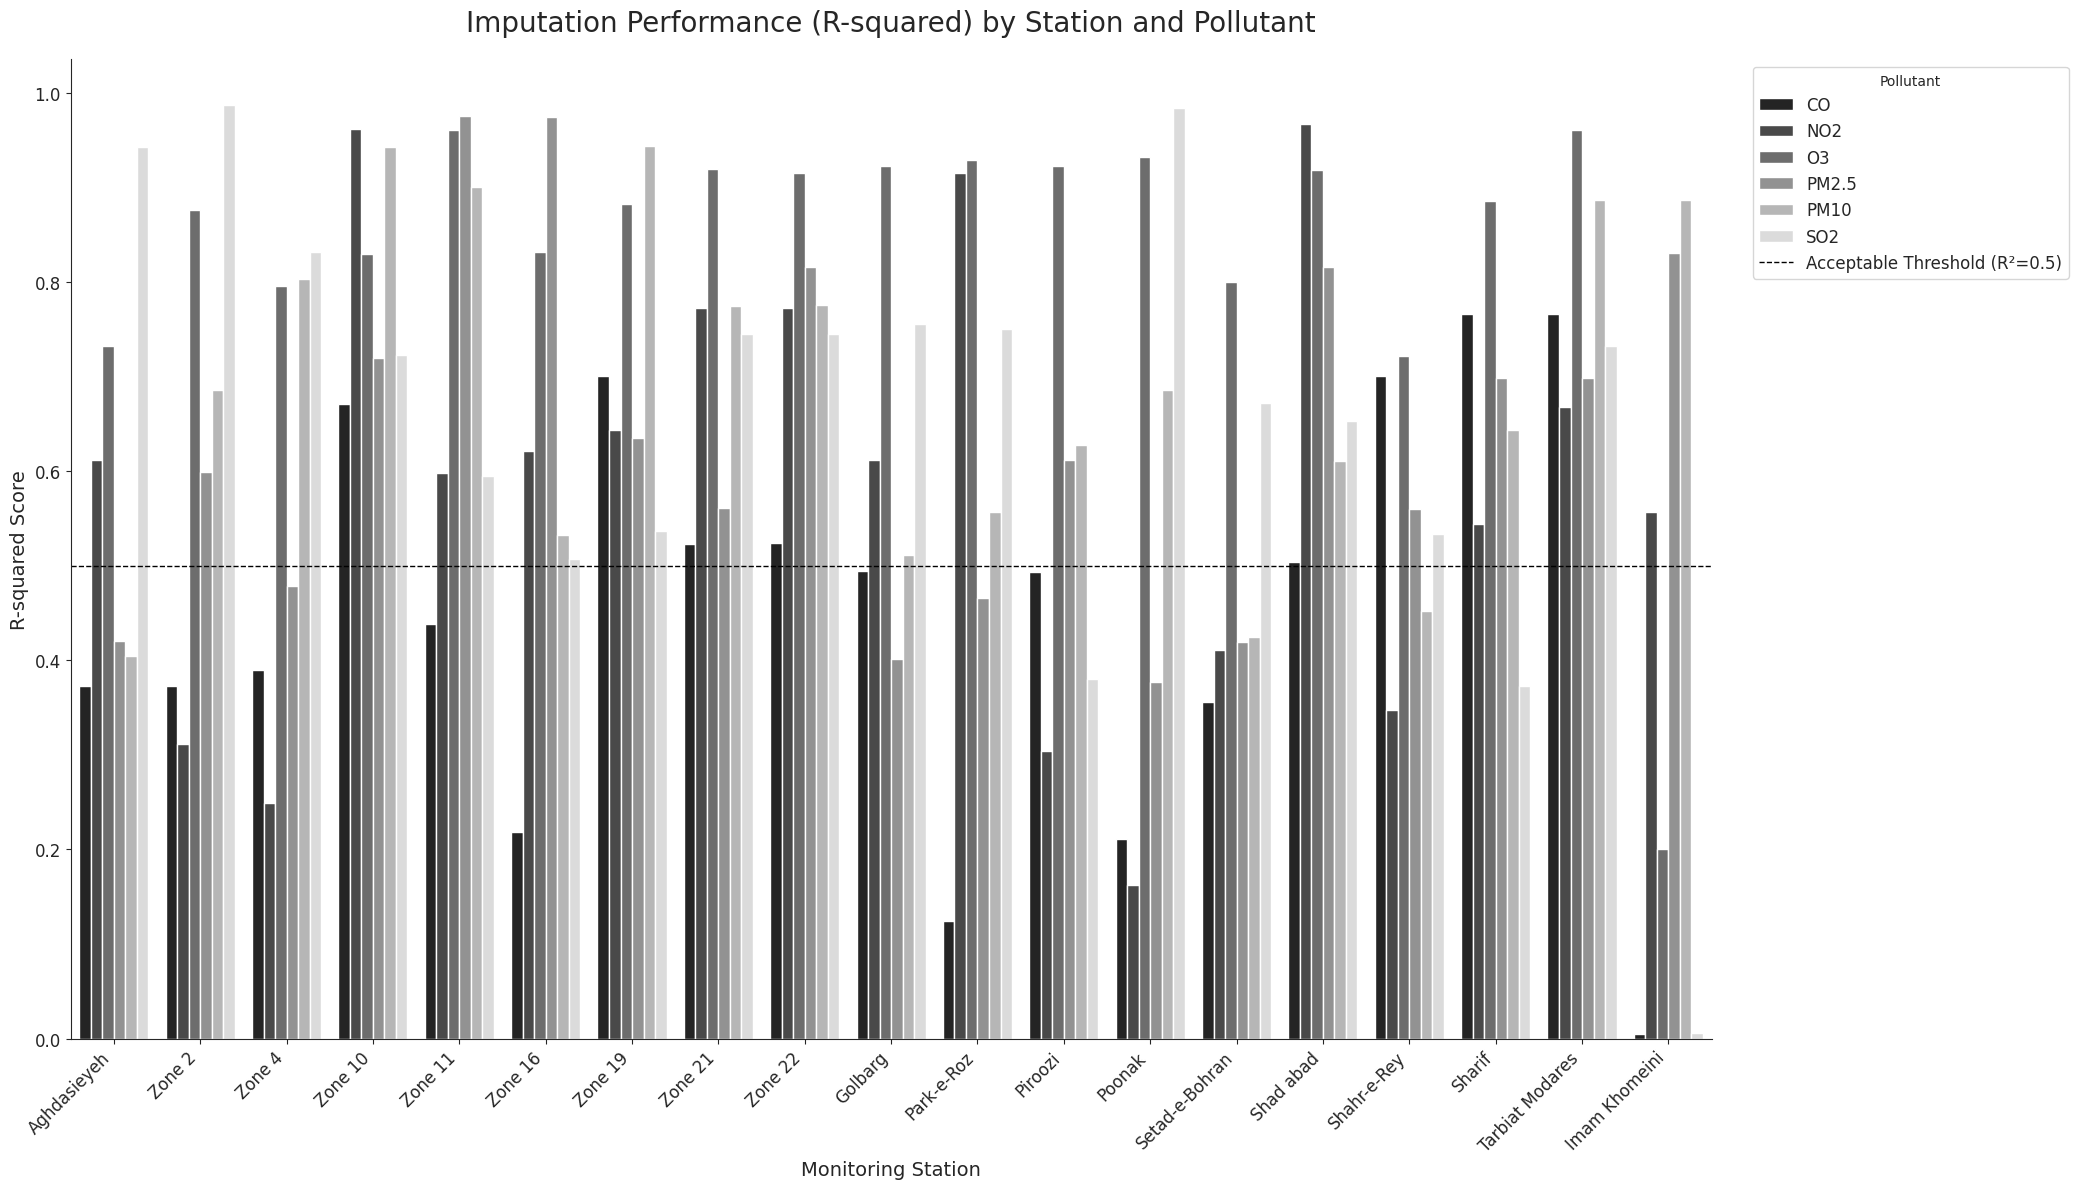

In [25]:
# Set a classic, academic-style plot
sns.set_style("ticks")

# Create the plot with a grayscale color palette for a professional look
plt.figure(figsize=(22, 12))
sns.barplot(data=results_df, x='Station', y='R2_Score', hue='Pollutant',
            palette='gray', dodge=True)

# Improve titles and labels for better readability and an academic feel
plt.title('Imputation Performance (R-squared) by Station and Pollutant', fontsize=20, pad=20)
plt.ylabel('R-squared Score', fontsize=14)
plt.xlabel('Monitoring Station', fontsize=14)

# Adjust tick parameters for a cleaner look
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
sns.despine() # Remove the top and right spines for a cleaner look

# Enhance the legend
plt.legend(title='Pollutant', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)


# Add a horizontal line at R2=0.5 for reference
plt.axhline(y=0.5, color='black', linestyle='--', linewidth=1, label='Acceptable Threshold (R²=0.5)')
plt.legend(title='Pollutant', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)


# Ensure everything fits without overlapping
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

In [26]:
def plot_evaluation_metric(metric):
    """
    Generates an interactive bar plot to visualize different evaluation metrics.

    Args:
        metric (str): The evaluation metric to plot ('R2_Score', 'MAE', 'RMSE').
    """
    # Set a professional and clean style
    sns.set_style("whitegrid")

    plt.figure(figsize=(22, 12))

    # Use a color palette that is both professional and visually appealing
    sns.barplot(data=results_df, x='Station', y=metric, hue='Pollutant',
                palette='coolwarm', dodge=True)

    # Set titles and labels based on the selected metric
    plt.title(f'Imputation Performance ({metric}) by Station and Pollutant', fontsize=20, pad=20)
    plt.ylabel(f'{metric} Score', fontsize=14)
    plt.xlabel('Monitoring Station', fontsize=14)

    # Adjust tick parameters for readability
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Enhance the legend
    plt.legend(title='Pollutant', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)

    # Add a reference line for R-squared if selected
    if metric == 'R2_Score':
        plt.axhline(y=0.5, color='darkblue', linestyle='--', linewidth=1.5, label='Acceptable Threshold (R²=0.5)')
        plt.legend(title='Pollutant', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=12)

    # Ensure the layout is tight and clean
    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()

# Create the interactive widget
interact(plot_evaluation_metric,
         metric=Dropdown(options=['R2_Score', 'MAE', 'RMSE'],
                         value='R2_Score',
                         description='Select Metric:'));

interactive(children=(Dropdown(description='Select Metric:', options=('R2_Score', 'MAE', 'RMSE'), value='R2_Sc…